# Initial study

This notebook identifies PPMI subjects to reproduce the following paper:


<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study used the following population from PPMI:
<img src="../data/table.png"/>

Note: this notebook can be shared publicly. It is implemented to not leak any PPMI patient information or id.

# Data loading and preparation

## Metadata download

In [1]:
import os
import ppmi_downloader

data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
required_files = ['Age_at_visit.csv', 'Demographics.csv',
                  'Magnetic_Resonance_Imaging__MRI_.csv', 'MDS_UPDRS_Part_III.csv']
missing_files = [x for x in required_files if not os.path.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    ppmi = ppmi_downloader.PPMIDownloader('ADD YOUR PPMI LOGIN', 'ADD YOUR PPMI PASSWORD')
    ppmi.download_metadata(missing_files, destination_dir=data_dir, headless=False, timeout=600)


## Hoehn & Yahr score

In [2]:
import pandas as pd

df_hy = pd.read_csv(os.path.join(data_dir, 'MDS_UPDRS_Part_III.csv'))

# Keep only H&Y values for PDSTATE=OFF or (PDSTATE=NaN and PDTRTMNT=0, i.e., patient is not medicated)
df_hy = df_hy[(df_hy['PDSTATE'] == 'OFF') | ((df_hy['PDSTATE'].isnull()) & (df_hy['PDTRTMNT'] == 0)) ]

# Drop useless columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Show H&Y stats
df_hy.groupby(['NHY'], dropna=False).count()

/home/glatard/venvs/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,PATNO,EVENT_ID,PDSTATE,PDTRTMNT
NHY,,,,
0,4143,4143,24,4143
1,1634,1634,434,1631
2,4221,4221,2270,4218
3,363,363,285,363
4,54,54,47,54
5,21,21,19,21
UR,51,51,12,51
NaN,5,5,2,5


## Demographics

Needed for sex.

In [3]:
demo = pd.read_csv(os.path.join(data_dir, 'Demographics.csv'))

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

#
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,943
1,1273


## Age at visit

<AxesSubplot:>

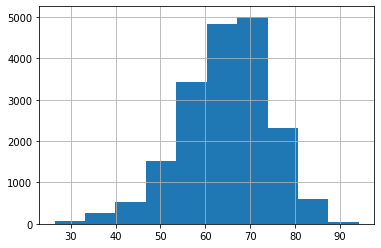

In [4]:
df_age = pd.read_csv(os.path.join(data_dir, 'Age_at_visit.csv'))

# Show histogram
df_age['AGE_AT_VISIT'].hist()

## MRI availability

In [5]:
mri_df = pd.read_csv(os.path.join(data_dir, 'Magnetic_Resonance_Imaging__MRI_.csv'))
keep_cols = ['EVENT_ID', 'PATNO', 'MRICMPLT']
mri_df = mri_df.drop([x for x in mri_df.columns if x not in keep_cols], axis=1)
mri_df.groupby('MRICMPLT').count()

,PATNO,EVENT_ID
MRICMPLT,,
0.0,498,498
1.0,2376,2376


## Merge H&Y, age and MRI information

In [6]:
keys = ['PATNO', 'EVENT_ID']
df = df_hy.merge(df_age, on=keys).merge(mri_df, on=keys)
df.columns

Index(['PATNO', 'EVENT_ID', 'PDSTATE', 'NHY', 'PDTRTMNT', 'AGE_AT_VISIT',
       'MRICMPLT'],
      dtype='object')

## Format data by visit pairs

In [7]:
# We need a 3-year gap between visits so the only possible pairs are the following ones:
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}
def next_visit(x):
    return visits[x]

In [8]:
# Keep only visit pairs for which the first visit is in the list of possible pairs
# and has MRI available
visits_df = df[(df['MRICMPLT']==1.0) & (df['EVENT_ID'].isin(visits))]

# Set id of second visit in pair
visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

# Retrieve H&Y score of next visit
visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

# Add patient sex to visit pairs
visits_df = visits_df.merge(demo, on=['PATNO'])

# Define visit as stable if NHY (first visit)
visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

<ipython-input-8-9360763f77c4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)


In [9]:
visits_df.groupby(['stable', 'NHY_x']).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  AGE_AT_VISIT  \
stable NHY_x                                                           
False  0        390         390          2         390           390   
       1        329         329         57         328           329   
       2        474         474        140         471           474   
       3         31          31         23          31            31   
       4          7           7          4           7             7   
       5          1           1          0           1             1   
       UR         1           1          1           1             1   
True   0        285         285          0         285           285   
       1         57          57         13          57            57   
       2        268         268        121         268           268   
       3          1           1          1           1             1   

              MRICMPLT  next_visit  EVENT_ID_y  PDSTATE_y  NHY_y  PDTRTMNT_y  \
stable NHY_x                                                                   
False  0           390         390          32          5     32          32   
       1           329         329         136        103    136         136   
       2           474         474          49         40     49          49   
       3            31          31           7          6      7           7   
       4             7           7           2          2      2           2   
       5             1           1           0          0      0           0   
       UR            1           1           0          0      0           0   
True   0           285         285         285          1    285         285   
       1            57          57          57         41     57          57   
       2           268         268         268        240    268         268   
       3             1           1           1          1      1           1   

              SEX  
stable NHY_x       
False  0      390  
       1      329  
       2      474  
       3       31  
       4        7  
       5        1  
       UR       1  
True   0      285  
       1       57  
       2      268  
       3        1

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [10]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,AGE_AT_VISIT,MRICMPLT,PDTRTMNT_y,SEX,AGE_AT_VISIT_norm
count,1844.000000,1840.000000,1844.000000,1844.0,837.000000,1844.00000,1.844000e+03
mean,43850.346529,0.194565,63.161226,1.0,0.523297,0.58026,-9.247845e-17
std,39937.796502,0.395973,8.923735,0.0,0.499756,0.49365,1.000000e+00
min,3001.000000,0.000000,32.200000,1.0,0.000000,0.00000,-3.469536e+00
25%,3691.500000,0.000000,57.275000,1.0,0.000000,0.00000,-6.596145e-01
50%,46546.000000,0.000000,63.800000,1.0,1.000000,1.00000,7.158150e-02
75%,70630.250000,0.000000,69.500000,1.0,1.000000,1.00000,7.103275e-01
max,151111.000000,1.000000,86.300000,1.0,1.000000,1.00000,2.592947e+00


## Matching loop

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [11]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = pd.unique(group1_df['PATNO'])
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)
    
    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# Apply matching to get 47 patients with H&Y=1
stable1, progr1 = match(47,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)

# Apply matching to get 25 patients with H&Y=2
stable2, progr2 = match(25,
                        df[(df['stable'] == True) & (df['NHY_x'] == "2")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "2")],
                        matched_vars)

In [12]:
stable = stable1.append(stable2)
progr = progr1.append(progr2)

## Sanity checks

In [13]:
for (a, b) in [(stable1, progr1), (stable2, progr2)]:
    # Both groups have equal size
    assert(len(a) == len(b))
    # No patient is present more than once in each group
    for x in [a, b]:
        patnos_x = pd.unique(x['PATNO'])
        assert(len(patnos_x)==len(x)), x
    # Patients in a aren't in b
    patnos_a = pd.unique(a['PATNO'])
    patnos_b = pd.unique(b['PATNO'])
    for p in patnos_a:
        assert(p not in patnos_b), f'PATNO {p} appears in a and b'
print('All good!')

All good!


## Cohort summary

In [14]:
import os
print(f"\t\t\t\t\t| Stable set (n={len(stable)})\t| Progression set (n={len(progr)})" + os.linesep +
       f"Age (years) \t\t\t\t| {round(stable['AGE_AT_VISIT'].mean(),2)} \t\t| {round(progr['AGE_AT_VISIT'].mean(),2)}" + os.linesep + 
       f"Gender [male (n)] \t\t\t| {len(stable[stable['SEX']==1])} \t\t\t| {len(progr[progr['SEX']==1])}" + os.linesep +
       f"Hoehn & Yahr (n) \t Stage 1 \t| {len(stable[stable['NHY_x']=='1'])} \t\t\t| {len(progr[progr['NHY_x']=='1'])}" + os.linesep +
       f"\t\t\t Stage 2 \t| {len(stable[stable['NHY_x']=='2'])} \t\t\t| {len(progr[progr['NHY_x']=='2'])}" + os.linesep +
       f"\t\t\t Stage 3 \t| {len(stable[stable['NHY_x']=='3'])} \t\t\t| {len(progr[progr['NHY_x']=='3'])}"

)

					| Stable set (n=72)	| Progression set (n=72)
Age (years) 				| 60.77 		| 60.8
Gender [male (n)] 			| 49 			| 49
Hoehn & Yahr (n) 	 Stage 1 	| 47 			| 47
			 Stage 2 	| 25 			| 25
			 Stage 3 	| 0 			| 0


<AxesSubplot:>

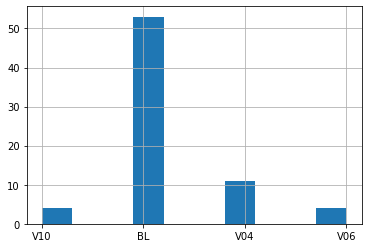

In [15]:
stable['EVENT_ID_x'].hist()

<AxesSubplot:>

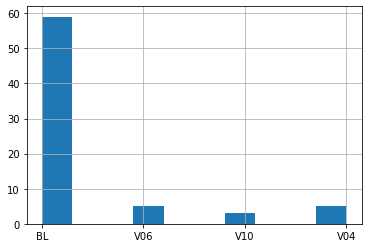

In [16]:
progr['EVENT_ID_x'].hist()